In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml

from tabulate import tabulate

from pathlib import Path

from librep.datasets.har.loaders import PandasMultiModalLoader
from librep.utils.dataset import PandasDatasetsIO
from librep.datasets.multimodal import PandasMultiModalDataset

In [6]:
# !pip install ../../hiaac-librep

In [7]:
dataset_names = ['kuhar', 'motionsense', 'uci', 'wisdm', 'realworld_thigh', 'realworld_waist']

# 1 - No reducer

In [8]:
data = []
for dataset in dataset_names:
    unit = {}
    unit['dataset'] = dataset
    with open(f'../execute_once_experiments/_previous/TV_sb_no_reducer/scores/no_reducer_{dataset}.yaml', 'r') as f:
        score = yaml.load(f, Loader=yaml.FullLoader)
        unit['sb_orig'] = score['score']
    with open(f'../execute_once_experiments/_previous/standartized_balanced_patrick_no_reducer/scores/balanced_patrick_no_reducer_{dataset}.yaml', 'r') as f:
        score = yaml.load(f, Loader=yaml.FullLoader)
        unit['sb_pat'] = score['score']
    with open(f'../execute_once_experiments/_previous/standartized_balanced_user_patrick_no_reducer/scores/bal_user_pat_no_reducer_{dataset}.yaml', 'r') as f:
        score = yaml.load(f, Loader=yaml.FullLoader)
        unit['sb_user'] = score['score']
    unit['sb_user - sb_orig'] = unit['sb_user'] - unit['sb_orig']
    data.append(unit)
print(tabulate(data, headers='keys', tablefmt='psql'))

+-----------------+-----------+----------+-----------+---------------------+
| dataset         |   sb_orig |   sb_pat |   sb_user |   sb_user - sb_orig |
|-----------------+-----------+----------+-----------+---------------------|
| kuhar           |  0.671127 | 0.693897 |  0.87037  |         0.199244    |
| motionsense     |  0.785952 | 0.899333 |  0.887745 |         0.101793    |
| uci             |  0.847059 | 0.857059 |  0.862222 |         0.0151634   |
| wisdm           |  0.747373 | 0.745847 |  0.747797 |         0.000423729 |
| realworld_thigh |  0.671521 | 0.576037 |  0.643991 |        -0.0275301   |
| realworld_waist |  0.787217 | 0.790939 |  0.821429 |         0.0342117   |
+-----------------+-----------+----------+-----------+---------------------+


# 2 - Difference in users

In [9]:
def get_TVT(route):
    train_processed, validation_processed, test_processed = PandasMultiModalLoader(
        Path(route)
    ).load(label="standard activity code")
    train_processed.data.reset_index(drop=True, inplace=True)
    validation_processed.data.reset_index(drop=True, inplace=True)
    test_processed.data.reset_index(drop=True, inplace=True)
    return train_processed, validation_processed, test_processed

In [10]:
def analyzing_one_view(route):
    print("Q1: How many users have samples in each section (train, val, test)?")
    train, val, test = get_TVT(route)
    train_unique_users = train.data["user"].unique()
    val_unique_users = val.data["user"].unique()
    test_unique_users = test.data["user"].unique()
    train_repeated = np.intersect1d(train_unique_users, list(val_unique_users) + list(test_unique_users))
    val_repeated = np.intersect1d(val_unique_users, list(train_unique_users) + list(test_unique_users))
    test_repeated = np.intersect1d(test_unique_users, list(train_unique_users) + list(val_unique_users))
    print("Users in training:", len(train_unique_users))
    print("Users in validation:", len(val_unique_users))
    print("Users in test:", len(test_unique_users))
    print("Users in training present in val or test:", train_repeated)
    print("Users in validation present in train or test:", val_repeated)
    print("Users in test present in train or validation:", test_repeated)
    print("Q2: How many samples are in each section (train, val, test)?")
    print("Samples in training:", len(train.data))
    print("Samples in validation:", len(val.data))
    print("Samples in test:", len(test.data))

In [11]:
def analyzing_two_views(route1, route2):
    print("Q1: How many users are present in each view?")
    train1, val1, test1 = get_TVT(route1)
    view1_unique_users = list(train1.data["user"].unique()) + list(val1.data["user"].unique()) + list(test1.data["user"].unique())
    print("Users in view 1:", len(view1_unique_users), "\n", sorted(view1_unique_users))
    train2, val2, test2 = get_TVT(route2)
    view2_unique_users = list(train2.data["user"].unique()) + list(val2.data["user"].unique()) + list(test2.data["user"].unique())
    print("Users in view 2:", len(view2_unique_users), "\n", sorted(view2_unique_users))
    print("Q2: How many users are present in both views?")
    view1_unique_users = set(view1_unique_users)
    view2_unique_users = set(view2_unique_users)
    print("Users in both views:", len(view1_unique_users.intersection(view2_unique_users)))

    print("Q3: How many users moved from one subset into another?")
    train1_df = pd.DataFrame(train1.data['user'].value_counts())
    val1_df = pd.DataFrame(val1.data['user'].value_counts())
    test1_df = pd.DataFrame(test1.data['user'].value_counts())
    all1_df = pd.concat([train1_df, val1_df, test1_df], axis=1, sort=False, keys=['train', 'val', 'test']).fillna(0)
    train2_df = pd.DataFrame(train2.data['user'].value_counts())
    val2_df = pd.DataFrame(val2.data['user'].value_counts())
    test2_df = pd.DataFrame(test2.data['user'].value_counts())
    all2_df = pd.concat([train2_df, val2_df, test2_df], axis=1, sort=False, keys=['train', 'val', 'test']).fillna(0)
    all_df = pd.concat([all1_df, all2_df], axis=1, sort=False, keys=['view1', 'view2']).fillna(0)
    all_df.columns = all_df.columns.map('-'.join).str.strip('|')
    check_train = ((all_df['view1-train-count'] > 0) & (all_df['view2-train-count'] > 0)) | ((all_df['view1-train-count'] == 0) & (all_df['view2-train-count'] == 0))
    check_val = ((all_df['view1-val-count'] > 0) & (all_df['view2-val-count'] > 0)) | ((all_df['view1-val-count'] == 0) & (all_df['view2-val-count'] == 0))
    check_test = ((all_df['view1-test-count'] > 0) & (all_df['view2-test-count'] > 0)) | ((all_df['view1-test-count'] == 0) & (all_df['view2-test-count'] == 0))
    data_filtered = all_df[~(check_train & check_val & check_test)]
    print(tabulate(data_filtered, headers='keys', tablefmt='psql'))

    print("Q4: What percentage represent the samples that moved from one subset into another?")
    total_samples_view1 = len(train1.data) + len(val1.data) + len(test1.data)
    print("Total samples from view1:", total_samples_view1)
    print(f"Samples that moved from train: {data_filtered['view1-train-count'].sum()} ({100*data_filtered['view1-train-count'].sum() / total_samples_view1}%)")
    print(f"Samples that moved from val: {data_filtered['view1-val-count'].sum()} ({100*data_filtered['view1-val-count'].sum() / total_samples_view1}%)")
    print(f"Samples that moved from test: {data_filtered['view1-test-count'].sum()} ({100*data_filtered['view1-test-count'].sum() / total_samples_view1}%)")
    total_samples_view2 = len(train2.data) + len(val2.data) + len(test2.data)
    print("Total samples from view2:", total_samples_view2)
    print(f"Samples that moved from train: {data_filtered['view2-train-count'].sum()} ({100*data_filtered['view2-train-count'].sum() / total_samples_view2}%)")
    print(f"Samples that moved from val: {data_filtered['view2-val-count'].sum()} ({100*data_filtered['view2-val-count'].sum() / total_samples_view2}%)")
    print(f"Samples that moved from test: {data_filtered['view2-test-count'].sum()} ({100*data_filtered['view2-test-count'].sum() / total_samples_view2}%)")
    

In [12]:
view1 = '../../data/standartized_balanced/KuHar'
view2 = '../../data/standartized_balanced_user_patrick/KuHar'
analyzing_two_views(view1, view2)

Q1: How many users are present in each view?
Users in view 1: 79 
 [1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1013, 1014, 1015, 1016, 1017, 1018, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1101]
Users in view 2: 18 
 [1002, 1004, 1023, 1024, 1026, 1027, 1034, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046]
Q2: How many users are present in both views?
Users in both views: 18
Q3: How many users moved from one subset into another?
+--------+---------------------+-------------------+--------------------+---------------------+-------------------+--------------------+
|   user |   view1-train-count |   view1-val-count |   view1-test

In [13]:
dataset_exact_names = ['KuHar'] #, 'MotionSense', 'UCI', 'WISDM', 'Realworld_thigh', 'Realworld_waist']
view_exact_names = ['standartized_balanced', 'standartized_balanced_patrick', 'standartized_balanced_user_patrick']

for view in view_exact_names:
    for dataset in dataset_exact_names:
        route = f'../../data/{view}/{dataset}'
        print(f"Analysing {view} - {dataset}")
        analyzing_one_view(route)
        print("")

Analysing standartized_balanced - KuHar
Q1: How many users have samples in each section (train, val, test)?
Users in training: 57
Users in validation: 7
Users in test: 15
Users in training present in val or test: []
Users in validation present in train or test: []
Users in test present in train or validation: []
Q2: How many samples are in each section (train, val, test)?
Samples in training: 1386
Samples in validation: 426
Samples in test: 144

Analysing standartized_balanced_patrick - KuHar
Q1: How many users have samples in each section (train, val, test)?
Users in training: 56
Users in validation: 7
Users in test: 15
Users in training present in val or test: []
Users in validation present in train or test: []
Users in test present in train or validation: []
Q2: How many samples are in each section (train, val, test)?
Samples in training: 1368
Samples in validation: 426
Samples in test: 168

Analysing standartized_balanced_user_patrick - KuHar
Q1: How many users have samples in each

In [14]:
# datasets = ["KuHar", "MotionSense", "WISDM", "UCI", "RealWorld_waist", "RealWorld_thigh"]
# views = [ "standartized_balanced", "standartized_balanced_patrick", "standartized_balanced_user_patrick"]
# for_analysis = [
#     {
#         "route": f"../../data/{view}/{dataset}/",
#     } for view in views for dataset in datasets
# ]
# # print(for_analysis)
# for item in for_analysis:
#     item["train"], item["validation"], item["test"] = get_TVT(item["route"])



In [15]:
data_kuhar_sb = get_TVT("../../data/standartized_balanced/KuHar/")

In [16]:
from tabulate import tabulate

In [17]:
analyzing_one_view("../../data/standartized_balanced/KuHar/")

Q1: How many users have samples in each section (train, val, test)?
Users in training: 57
Users in validation: 7
Users in test: 15
Users in training present in val or test: []
Users in validation present in train or test: []
Users in test present in train or validation: []
Q2: How many samples are in each section (train, val, test)?
Samples in training: 1386
Samples in validation: 426
Samples in test: 144


In [18]:
# analyzing_2_view("../../data/standartized_balanced/KuHar/", "../../data/standartized_balanced_patrick/KuHar/")

In [19]:
def plot_users_from_view(route):
    train, val, test = get_TVT(route)
    train_df = pd.DataFrame(train.data["user"].value_counts())
    val_df = pd.DataFrame(val.data["user"].value_counts())
    test_df = pd.DataFrame(test.data["user"].value_counts())
    all_df = pd.concat([train_df, val_df, test_df], axis=1, sort=False, keys=['train', 'val', 'test'])   
    all_df.fillna(0).astype(int).plot.bar(figsize=(20,10)) 

<BarContainer object of 24 artists>

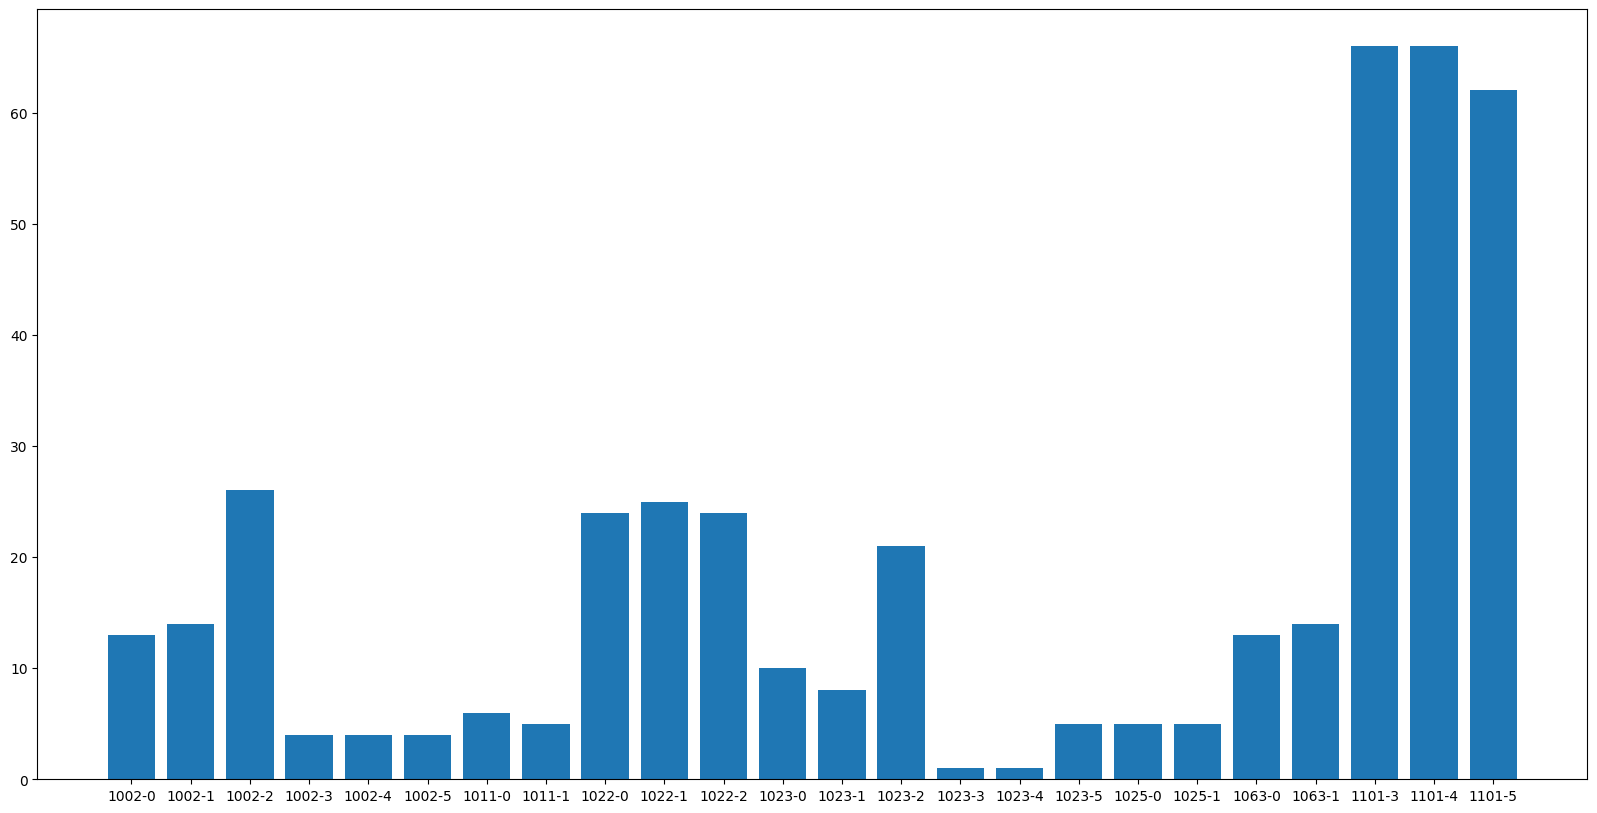

In [20]:
val, train, test = get_TVT("../../data/standartized_balanced/KuHar/")
# train.data.columns
train_df = train.data.groupby(['user', 'standard activity code']).count().reset_index()
train_df['x'] = train_df['user'].astype(str) + '-' + train_df['standard activity code'].astype(str)

plt.figure(figsize=(20,10))
plt.bar(train_df['x'], train_df['accel-x-0'])
# train_df.plot.bar(figsize=(20,10))

In [54]:
# titles = ['standartized_balanced', 'standartized_balanced_updated', 'standartized_balanced_user_upda']
import plotly.express as px
for dataset in ["KuHar", "MotionSense", "WISDM", "UCI", "RealWorld_waist", "RealWorld_thigh"]:
    for view in ["standartized_balanced_user_patrick"]: #["standartized_balanced", "standartized_balanced_patrick", "standartized_balanced_user_patrick"]:
        train, val, test = get_TVT(f"../../data/{view}/{dataset}/")
        focus_df = val.data.sort_values(by=['standard activity code']).groupby('standard activity code').count().reset_index()
        print(f'{view}-{dataset}', focus_df[0:1]['accel-x-0'])
        # focus_df['user'] = focus_df['user'].astype(str)
        # focus_df['samples'] = 1
        # df = focus_df
        # fig = px.bar(df, x='standard activity code', y='samples', color='user', barmode='stack').update_layout({'title': view + '-' + dataset})
        # fig.show()
        # Save images
        # print(f"{view}-{dataset}-validation.jpeg")
        

standartized_balanced_user_patrick-KuHar 0    18
Name: accel-x-0, dtype: int64
standartized_balanced_user_patrick-MotionSense 0    68
Name: accel-x-0, dtype: int64
standartized_balanced_user_patrick-WISDM 0    236
Name: accel-x-0, dtype: int64
standartized_balanced_user_patrick-UCI 0    63
Name: accel-x-0, dtype: int64
standartized_balanced_user_patrick-RealWorld_waist 0    294
Name: accel-x-0, dtype: int64
standartized_balanced_user_patrick-RealWorld_thigh 0    147
Name: accel-x-0, dtype: int64


In [30]:
# titles = ['standartized_balanced', 'standartized_balanced_updated', 'standartized_balanced_user_upda']
import plotly.express as px
for dataset in ["KuHar", "MotionSense", "WISDM", "UCI", "RealWorld_waist", "RealWorld_thigh"]:
    for view in ["standartized_balanced", "standartized_balanced_patrick", "standartized_balanced_user_patrick"]:
        train, val, test = get_TVT(f"../../data/{view}/{dataset}/")
        focus_df = val.data.sort_values(by=['user', 'standard activity code'])
        focus_df['user'] = focus_df['user'].astype(str)
        focus_df['samples'] = 1
        df = focus_df
        fig = px.bar(df, x='standard activity code', y='samples', color='user', barmode='stack').update_layout({'title': view + '-' + dataset})
        fig.show()
        # Save images
        print(f"{view}-{dataset}-validation.jpeg")
        

standartized_balanced-KuHar-validation.jpeg


standartized_balanced_patrick-KuHar-validation.jpeg


standartized_balanced_user_patrick-KuHar-validation.jpeg


standartized_balanced-MotionSense-validation.jpeg


standartized_balanced_patrick-MotionSense-validation.jpeg


standartized_balanced_user_patrick-MotionSense-validation.jpeg


standartized_balanced-WISDM-validation.jpeg


standartized_balanced_patrick-WISDM-validation.jpeg


standartized_balanced_user_patrick-WISDM-validation.jpeg


standartized_balanced-UCI-validation.jpeg


standartized_balanced_patrick-UCI-validation.jpeg


standartized_balanced_user_patrick-UCI-validation.jpeg


standartized_balanced-RealWorld_waist-validation.jpeg


standartized_balanced_patrick-RealWorld_waist-validation.jpeg


standartized_balanced_user_patrick-RealWorld_waist-validation.jpeg


standartized_balanced-RealWorld_thigh-validation.jpeg


standartized_balanced_patrick-RealWorld_thigh-validation.jpeg


standartized_balanced_user_patrick-RealWorld_thigh-validation.jpeg


In [22]:
# !pip install -U kaleido

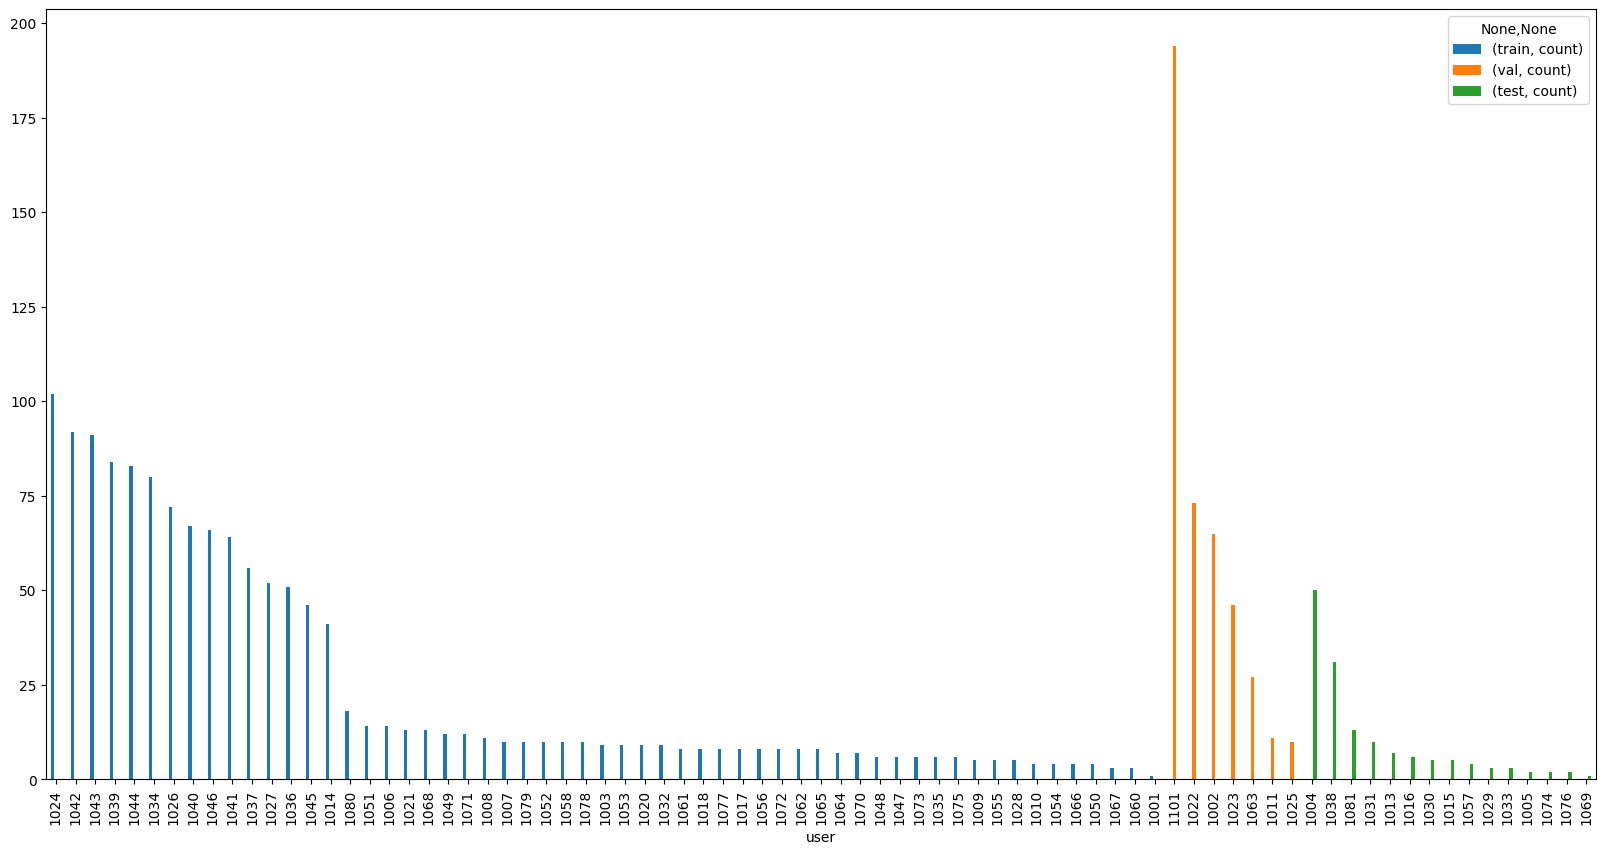

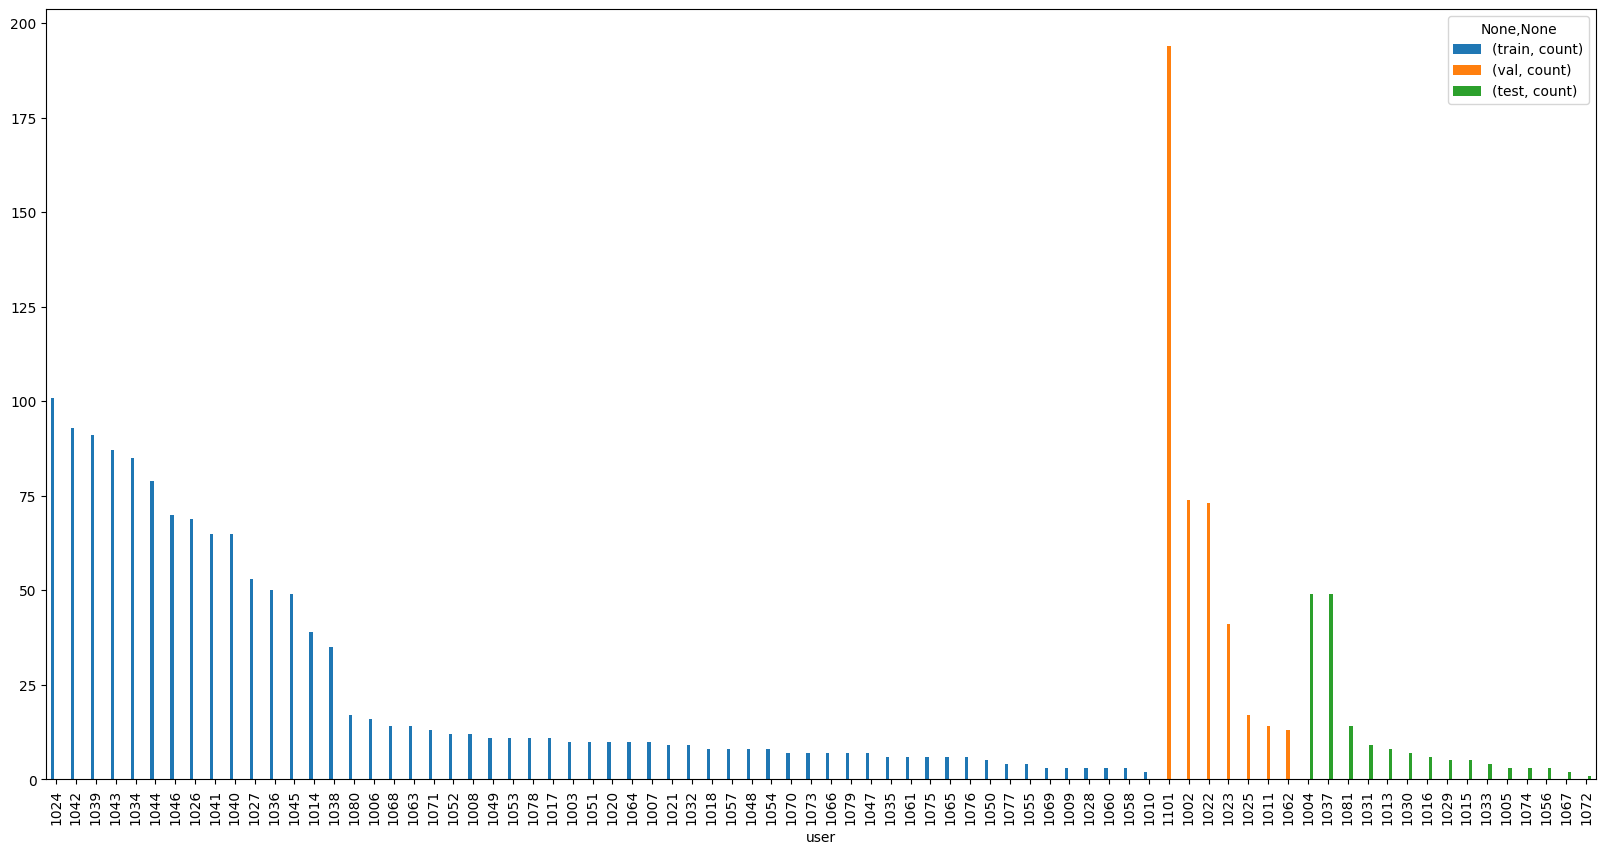

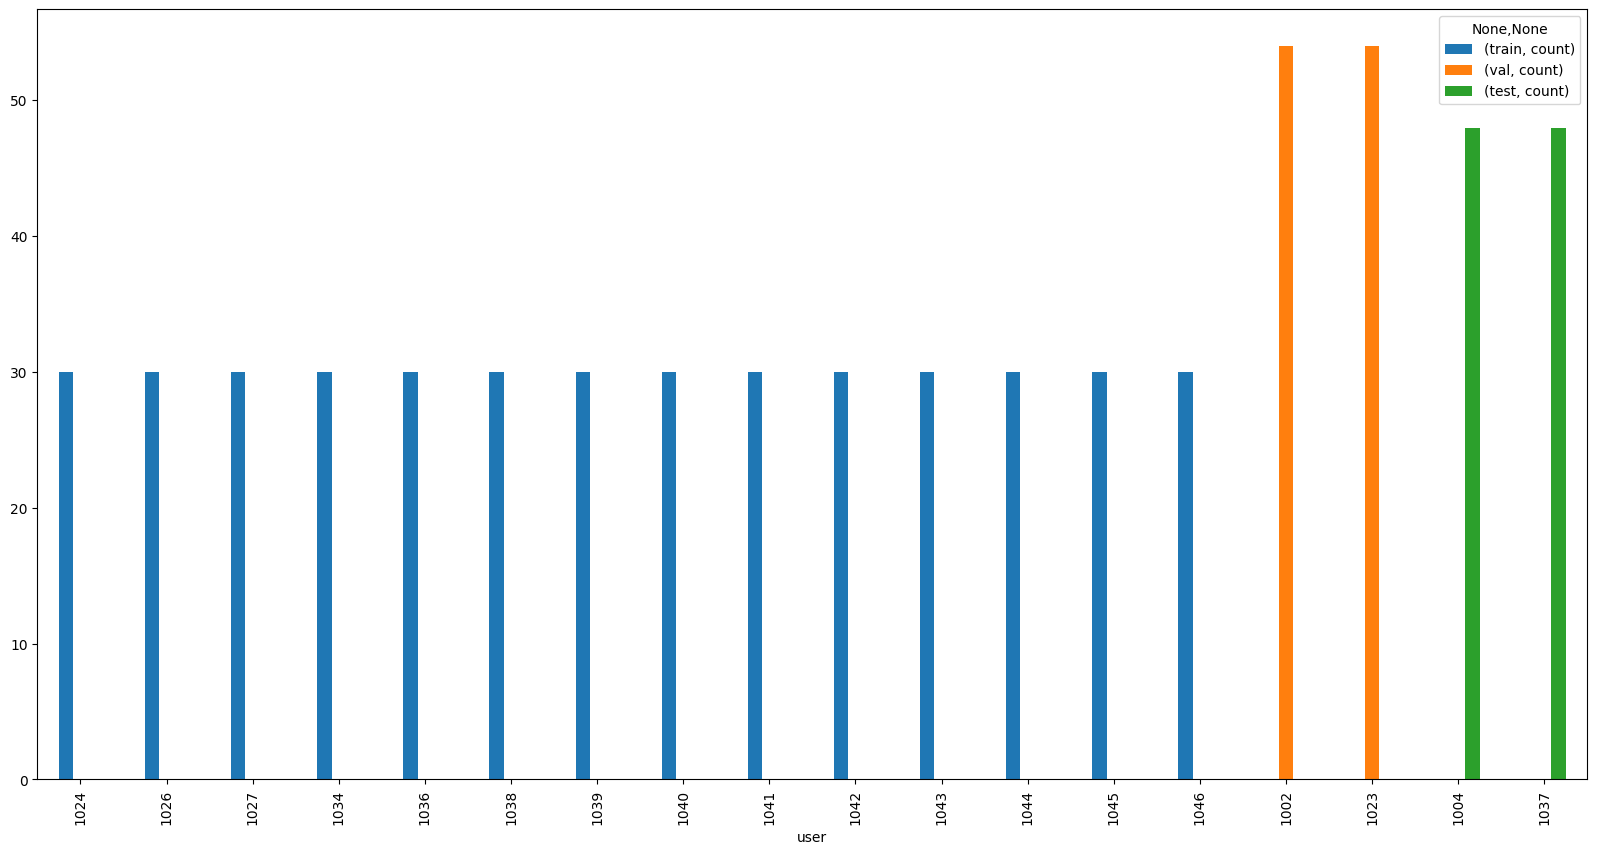

In [23]:
plot_users_from_view("../../data/standartized_balanced/KuHar/")
plot_users_from_view("../../data/standartized_balanced_patrick/KuHar/")
plot_users_from_view("../../data/standartized_balanced_user_patrick/KuHar/")

      train   val  test
      count count count
user                   
1024  102.0   NaN   NaN
1042   92.0   NaN   NaN
1043   91.0   NaN   NaN
1039   84.0   NaN   NaN
1044   83.0   NaN   NaN
...     ...   ...   ...
1033    NaN   NaN   3.0
1005    NaN   NaN   2.0
1074    NaN   NaN   2.0
1076    NaN   NaN   2.0
1069    NaN   NaN   1.0

[79 rows x 3 columns]


<Axes: xlabel='user'>

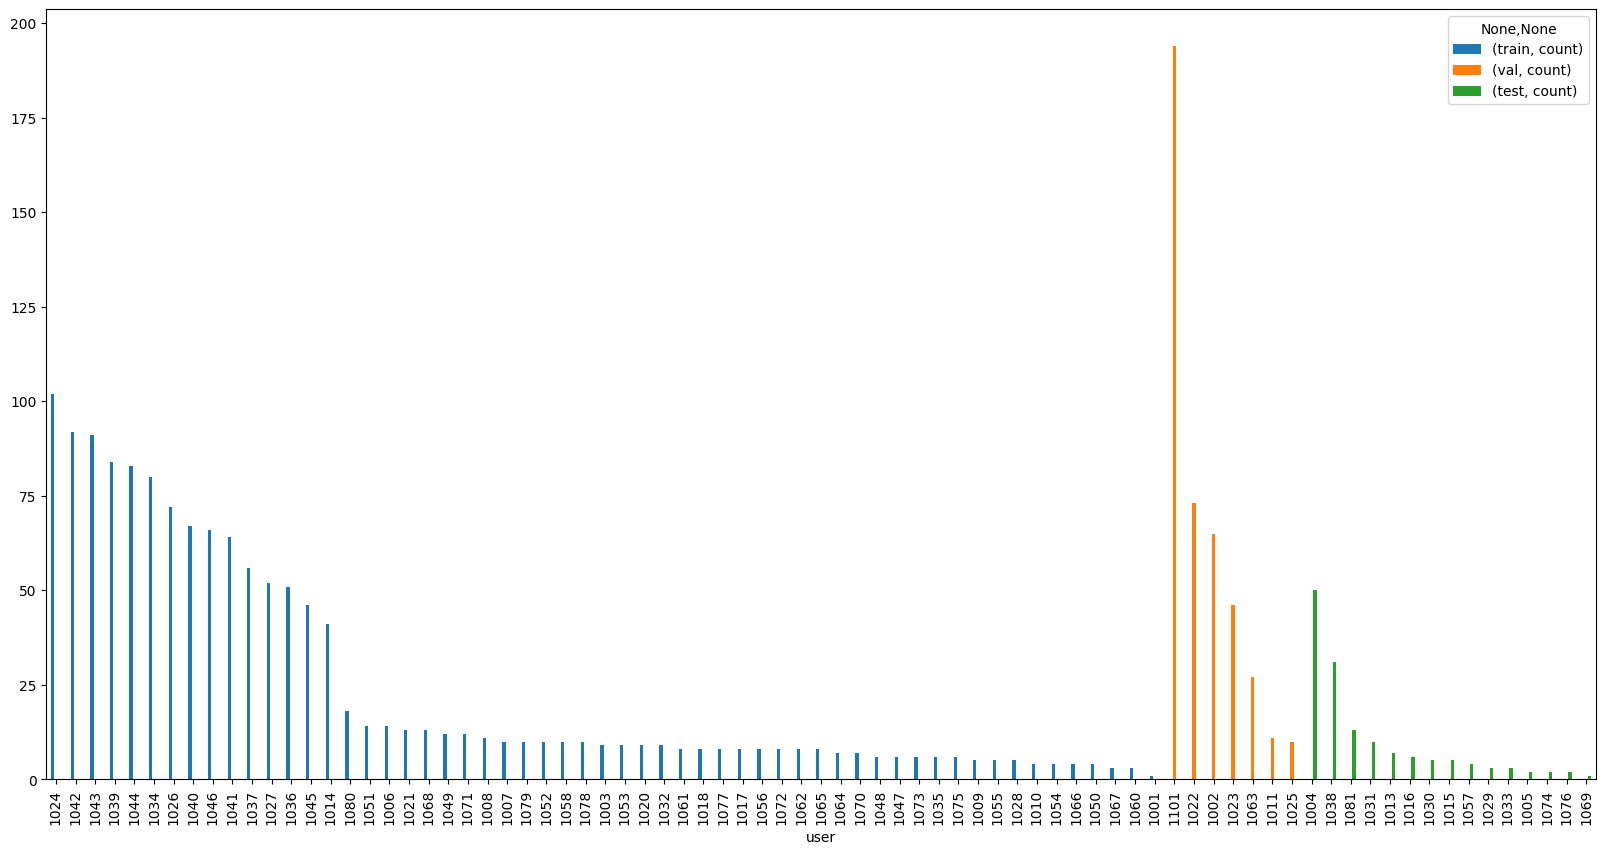

In [24]:
# TRAIN
train_df = pd.DataFrame(data_kuhar_sb[0].data["user"].value_counts())
val_df = pd.DataFrame(data_kuhar_sb[1].data["user"].value_counts())
test_df = pd.DataFrame(data_kuhar_sb[2].data["user"].value_counts())
all_df = pd.concat([train_df, val_df, test_df], axis=1, sort=False, keys=['train', 'val', 'test'])
print(all_df)
all_df.fillna(0).astype(int).plot.bar(figsize=(20,10))

# print(train_df)

In [25]:
def load_data(dataset, view, df, sample_rate, labels_activity):

    path = "../../data/"
    processed_view_path = Path(path) / view / dataset

    total_samples_per_activity = {
        "train": {
            activity: 0 for activity in labels_activity.keys()
        },
        "validation": {
            activity: 0 for activity in labels_activity.keys()
        },
        "test": {
            activity: 0 for activity in labels_activity.keys()
        },
    }

    total_users_per_activity = {
        "train": {
            activity: 0 for activity in labels_activity.keys()
        },
        "validation": {
            activity: 0 for activity in labels_activity.keys()
        },
        "test": {
            activity: 0 for activity in labels_activity.keys()
        },
    }

    if view == "unbalanced":
        # Load unbalanced data
        loader = PandasDatasetsIO(
            processed_view_path,
            train_filename="unbalanced.csv",
            validation_filename=None,
            test_filename=None,
        )
        data_processed = loader.load(
            load_train=True,
            load_validation=False,
            load_test=False,
        )[0]

        total_samples_train = len(data_processed)
        total_users_train = len(data_processed["user"].unique())

        total_samples = total_samples_train
        total_users = total_users_train

        total_samples_validation = 0
        total_samples_test = 0

        total_users_validation = 0
        total_users_test = 0

        total_activities = len(data_processed["standard activity code"].unique())

        for activity in data_processed["standard activity code"].unique():
            total_samples_per_activity["train"][activity] = len(
                data_processed[data_processed["standard activity code"] == activity]
            )

            total_users_per_activity["train"][activity] = len(
                data_processed[data_processed["standard activity code"] == activity]["user"].unique()
            )

    else:

        train_processed, validation_processed, test_processed = PandasMultiModalLoader(
            processed_view_path
        ).load(label="standard activity code")

        train_processed.data.reset_index(drop=True, inplace=True)

        validation_processed.data.reset_index(drop=True, inplace=True)

        test_processed.data.reset_index(drop=True, inplace=True)

        total_samples_train = len(train_processed.data)
        total_samples_validation = len(validation_processed.data)
        total_samples_test = len(test_processed.data)

        total_users_train = len(train_processed.data["user"].unique())
        total_users_validation = len(validation_processed.data["user"].unique())
        total_users_test = len(test_processed.data["user"].unique())

        total_samples = total_samples_train + total_samples_validation + total_samples_test
        total_users = total_users_train + total_users_validation + total_users_test

        total_activities = len(train_processed.data["standard activity code"].unique())

        sample_rate =  20 if view not in ["raw_balanced", "raw_balanced_user"] else sample_rate

        for activity in train_processed.data["standard activity code"].unique():
            total_samples_per_activity["train"][activity] = len(
                train_processed.data[train_processed.data["standard activity code"] == activity]
            )
            total_samples_per_activity["validation"][activity] = len(
                validation_processed.data[
                    validation_processed.data["standard activity code"] == activity
                ]
            )
            total_samples_per_activity["test"][activity] = len(
                test_processed.data[test_processed.data["standard activity code"] == activity]
            )

            total_users_per_activity["train"][activity] = len(
                train_processed.data[train_processed.data["standard activity code"] == activity]["user"].unique()
            )
            total_users_per_activity["validation"][activity] = len(
                validation_processed.data[
                    validation_processed.data["standard activity code"] == activity
                ]["user"].unique()
            )
            total_users_per_activity["test"][activity] = len(
                test_processed.data[test_processed.data["standard activity code"] == activity]["user"].unique()
            )

    df["dataset"] = dataset
    df["view"] = view
    df["sample rate"] = sample_rate

    df["total of samples"] = total_samples
    df["total of users"] = total_users

    df["samples per train"] = total_samples_train
    df["samples per validation"] = total_samples_validation
    df["samples per test"] = total_samples_test

    df["users per train"] = total_users_train
    df["users per validation"] = total_users_validation
    df["users per test"] = total_users_test

    df["total of activities"] = total_activities

    for key, activity in labels_activity.items():
        df[f"total activities: {activity}"] = total_samples_per_activity["train"][key] + total_samples_per_activity["validation"][key] + total_samples_per_activity["test"][key]
        df[f"total activities in train: {activity}"] = total_samples_per_activity["train"][key]
        df[f"total activities in validation: {activity}"] = total_samples_per_activity["validation"][key]
        df[f"total activities in test: {activity}"] = total_samples_per_activity["test"][key]

        df[f"total users: {activity}"] = total_users_per_activity["train"][key] + total_users_per_activity["validation"][key] + total_users_per_activity["test"][key]
        df[f"total users in train: {activity}"] = total_users_per_activity["train"][key]
        df[f"total users in validation: {activity}"] = total_users_per_activity["validation"][key]
        df[f"total users in test: {activity}"] = total_users_per_activity["test"][key]

    return df

In [26]:
datasets = [
    "KuHar",
    "MotionSense",
    "UCI",
    "WISDM",
    "RealWorld_thigh",
    "RealWorld_waist",
]

columns = [
    "dataset",
    "view",
    "sample rate",
    "total of samples",
    "total of users",
    "total of activities",

    "samples per train",
    "samples per validation",
    "samples per test",

    "users per train",
    "users per validation",
    "users per test",
]

sample_rates = {
    "KuHar": 100,
    "MotionSense": 50,
    "UCI": 50,
    "WISDM": 20,
    "RealWorld_thigh": 50,
    "RealWorld_waist": 50,
}

views = [
    # "unbalanced", 
    # "raw_balanced", 
    # "raw_balanced_user", 
    "standartized_balanced", 
    "standartized_balanced_user_patrick", 
    # "standartized_inter_balanced", 
    # "standartized_inter_balanced_user"
]

labels_activity = {
    0: "sit",
    1: "stand",
    2: "walk",
    3: "stair up",
    4: "stair down",
    5: "run",
    6: "stair up and down",
}

columns += [f"total activities: {activity}" for activity in labels_activity.values()]
columns

['dataset',
 'view',
 'sample rate',
 'total of samples',
 'total of users',
 'total of activities',
 'samples per train',
 'samples per validation',
 'samples per test',
 'users per train',
 'users per validation',
 'users per test',
 'total activities: sit',
 'total activities: stand',
 'total activities: walk',
 'total activities: stair up',
 'total activities: stair down',
 'total activities: run',
 'total activities: stair up and down']

In [27]:
dfs = []

for dataset in datasets:
    for view in views:
        df = {column: None for column in columns}
        df = load_data(dataset, view, df, sample_rates[dataset], labels_activity)
        dfs.append(df)
df = pd.DataFrame(dfs)
df

,dataset,view,sample rate,total of samples,total of users,total of activities,samples per train,samples per validation,samples per test,users per train,...,total users in train: run,total users in validation: run,total users in test: run,total activities in train: stair up and down,total activities in validation: stair up and down,total activities in test: stair up and down,total users: stair up and down,total users in train: stair up and down,total users in validation: stair up and down,total users in test: stair up and down
0,KuHar,standartized_balanced,20,1956,79,6,1386,426,144,57,...,16,3,3,0,0,0,0,0,0,0
1,KuHar,standartized_balanced_user_patrick,20,624,18,6,420,108,96,14,...,14,2,2,0,0,0,0,0,0,0
2,MotionSense,standartized_balanced,20,5040,24,6,3558,420,1062,17,...,17,2,5,0,0,0,0,0,0,0
3,MotionSense,standartized_balanced_user_patrick,20,3204,24,6,1836,408,960,17,...,17,2,5,0,0,0,0,0,0,0
4,UCI,standartized_balanced,20,3450,30,5,2420,340,690,21,...,0,0,0,0,0,0,0,0,0,0
5,UCI,standartized_balanced_user_patrick,20,2880,30,5,1995,315,570,21,...,0,0,0,0,0,0,0,0,0,0
6,WISDM,standartized_balanced,20,15345,51,5,10920,1180,3245,36,...,36,4,11,2184,236,649,51,36,4,11
7,WISDM,standartized_balanced_user_patrick,20,15045,51,5,10620,1180,3245,36,...,36,4,11,2124,236,649,51,36,4,11
8,RealWorld_thigh,standartized_balanced,20,15084,15,6,10332,1854,2898,10,...,10,2,3,0,0,0,0,0,0,0
9,RealWorld_thigh,standartized_balanced_user_patrick,20,11910,14,6,8400,882,2628,10,...,10,1,3,0,0,0,0,0,0,0


# 2 - The best old in KuHar, now

In [28]:
print('Best configuration of old-balanced KUHAR')
with open(f'../experiments/umap_kuhar_p100/best.yaml', 'r') as f:
    score = yaml.load(f, Loader=yaml.FullLoader)
    for key in score['config']:
        print(key, score['config'][key])
    print('Old best score:', score['score'])

with open(f'../execute_once_experiments/scores/balanced_patrick_umap_kuhar_p100_best.yaml', 'r') as f:
    score = yaml.load(f, Loader=yaml.FullLoader)
    print('New best score:', score['score'])

Best configuration of old-balanced KUHAR
umap_epochs 173
umap_mdist 0.17469232166208573
umap_ncomp 334
umap_neigh 5
umap_spread 1.9923078093206665
Old best score: 0.41784037558685444
New best score: 0.3873239436619718


# 3 - Comparing hyperparameters explorations

Text(0, 0.5, 'Best accuracy obtained after hyperparameters search')

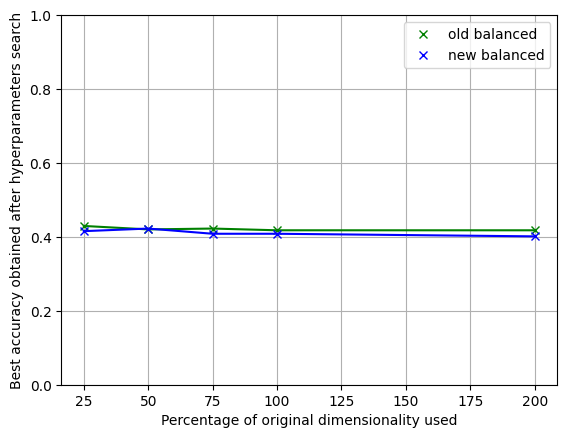

In [29]:
percentages = [25, 50, 75, 100, 200]

data_old = []
data_new = []

for p in percentages:
    with open(f'../experiments/umap_kuhar_p{p}/best.yaml') as f:
        score = yaml.load(f, Loader=yaml.FullLoader)
        data_old.append(score['score'])
    try:
        with open(f'../experiments/pbal_umap_kuhar_p{p}/best.yaml') as f:
            score = yaml.load(f, Loader=yaml.FullLoader)
            data_new.append(score['score'])
    except:
        data_new.append(np.nan)

plt.plot(percentages, data_old, color='green')
plt.plot(percentages, data_old, 'x', label='old balanced', color='green')
plt.plot(percentages, data_new, color='blue')
plt.plot(percentages, data_new, 'x', label='new balanced', color='blue')
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.xlabel('Percentage of original dimensionality used')
plt.ylabel('Best accuracy obtained after hyperparameters search')